In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
from matplotlib.patches import Ellipse
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

/kaggle/input/clustering-penguins-species/penguins.csv


## EDA + Feature Engineering

In [2]:
data = pd.read_csv("/kaggle/input/clustering-penguins-species/penguins.csv")
data

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...
339,NaN,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0,FEMALE
341,50.4,15.7,222.0,5750.0,MALE
342,45.2,14.8,212.0,5200.0,FEMALE


In [3]:
data.isna().sum()

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64

In [4]:
data = data.dropna()
data

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
4,36.7,19.3,193.0,3450.0,FEMALE
5,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,FEMALE
340,46.8,14.3,215.0,4850.0,FEMALE
341,50.4,15.7,222.0,5750.0,MALE
342,45.2,14.8,212.0,5200.0,FEMALE


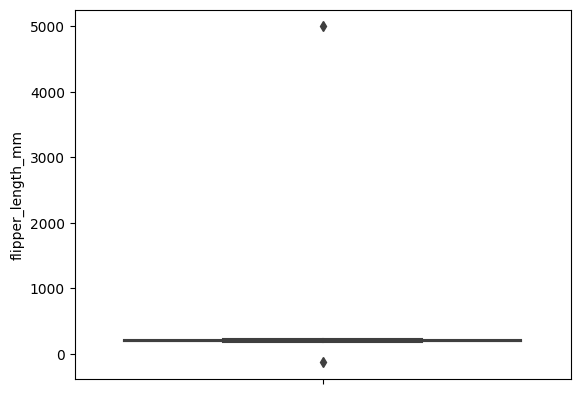

In [5]:
sns.boxplot(data, y="flipper_length_mm")
plt.show()

In [6]:
data = data[(data.flipper_length_mm < 1000) & (data.flipper_length_mm > 0)]

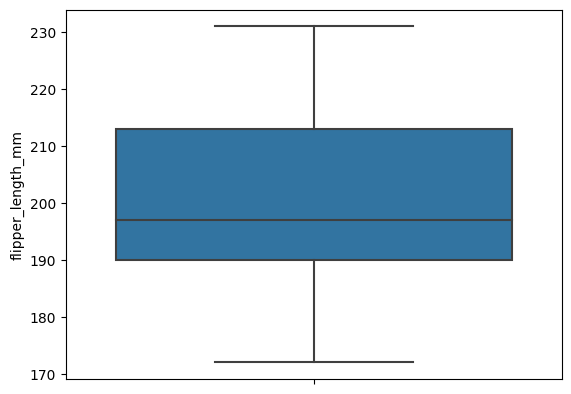

In [7]:
sns.boxplot(data, y="flipper_length_mm")
plt.show()

In [8]:
data.loc[data.sex == "MALE", "sex"] = 0
data.loc[data.sex == "FEMALE", "sex"] = 1
data = data[data.sex.isin([0,1])]
data

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,1
2,40.3,18.0,195.0,3250.0,1
4,36.7,19.3,193.0,3450.0,1
5,39.3,20.6,190.0,3650.0,0
...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,1
340,46.8,14.3,215.0,4850.0,1
341,50.4,15.7,222.0,5750.0,0
342,45.2,14.8,212.0,5200.0,1


In [9]:
X = data

## Scaler y PCA

In [10]:
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(X), index=X.index)

In [11]:
pca = PCA()
X = pd.DataFrame(pca.fit_transform(X), index=X.index)

In [12]:
exp_var = pd.DataFrame(pca.explained_variance_ratio_, columns=["explained_variance"])
exp_var["exp_var_cumsum"] = exp_var.explained_variance.cumsum()
exp_var

,explained_variance,exp_var_cumsum
0,0.568206,0.568206
1,0.281532,0.849738
2,0.096337,0.946075
3,0.033993,0.980067
4,0.019933,1.000000


In [13]:
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(data), index=X.index)
pca = PCA(2) #Usemos 2 componentes
X = pd.DataFrame(pca.fit_transform(X), index=data.index)

## Hierarchical clustering

In [14]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [15]:
X_sample = X.sample(20) #Hagamos un muestreo de los datos para ver un clustering jerarquico
ag = AgglomerativeClustering(distance_threshold=0,
                             n_clusters=None, linkage="complete") #Puedes cambiar el linkage a average, single o ward. 
ag.fit(X_sample) #Entrenamos el clustering

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

In [16]:
node_index = len(ag.labels_)
counts = np.zeros(node_index)
print("Tuple","->", "node", "->", "distance", sep="\t")
for i, (child, distance) in enumerate(zip(ag.children_, ag.distances_)):
    print(child, "->", node_index, "->", round(distance, 3), sep="\t")
    node_index+=1
#Ir explicando acá como se van formando los nodos.

Tuple	->	node	->	distance
[ 2 17]	->	20	->	0.095
[ 4 20]	->	21	->	0.149
[13 16]	->	22	->	0.192
[11 12]	->	23	->	0.255
[15 18]	->	24	->	0.283
[5 7]	->	25	->	0.299
[0 9]	->	26	->	0.467
[6 8]	->	27	->	0.473
[21 25]	->	28	->	0.608
[19 22]	->	29	->	0.628
[ 1 14]	->	30	->	0.693
[10 23]	->	31	->	0.753
[ 3 29]	->	32	->	0.855
[24 28]	->	33	->	1.048
[26 32]	->	34	->	1.403
[27 34]	->	35	->	2.018
[30 31]	->	36	->	2.735
[35 36]	->	37	->	4.564
[33 37]	->	38	->	4.974


In [17]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0]) #Es un array con la cantidad de elementos que hay en children
    n_samples = len(model.labels_) #El número de puntos etiquetados
    for i, merge in enumerate(model.children_): #Por cada children
        #For para ir actualizando el conteo de elementos de cada nodo
        current_count = 0
        for child_idx in merge: #Cada item de la tupla
            if child_idx < n_samples: #Si es menor al número de samples (es un dato)
                current_count += 1
            else: #Sino, es un grupo
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float) #Array de 4 columnas, los nodos, la distancia y la cantidad de elementos de cada nodo.
    return dendrogram(linkage_matrix, **kwargs) #La función dendrogram crea uno a partir de la matriz de linkage

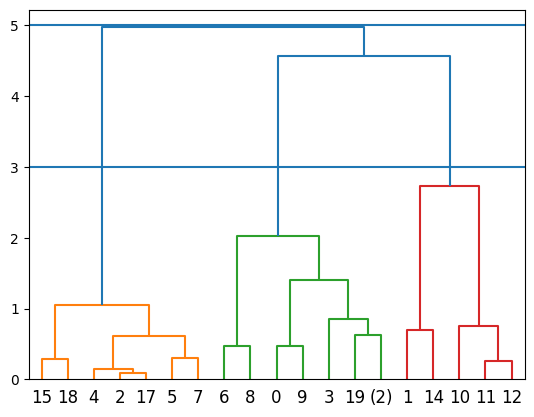

In [18]:
plot_dendrogram(ag, truncate_mode="level", p =5) #Puedes ir jugando con el truncamiento y la cantidad de pisos que quieres ver
plt.axhline(5) #Linea de corte para seleccionar el número de clusters
plt.axhline(3) #Linea de corte para seleccionar el número de clusters
plt.show()

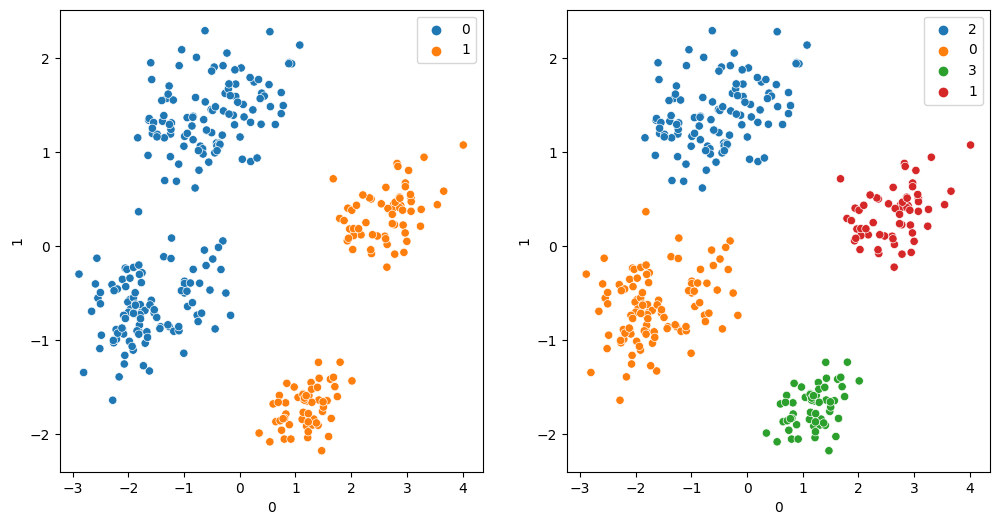

In [19]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
ag = AgglomerativeClustering(n_clusters=2)
y = ag.fit_predict(X).astype(str)
sns.scatterplot(X, x=0, y=1, hue=y)

plt.subplot(1,2,2)
ag = AgglomerativeClustering(n_clusters=4)
y = ag.fit_predict(X).astype(str)
sns.scatterplot(X, x=0, y=1, hue=y)
plt.show()

## Kmeans

### Optimal number of clusters

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

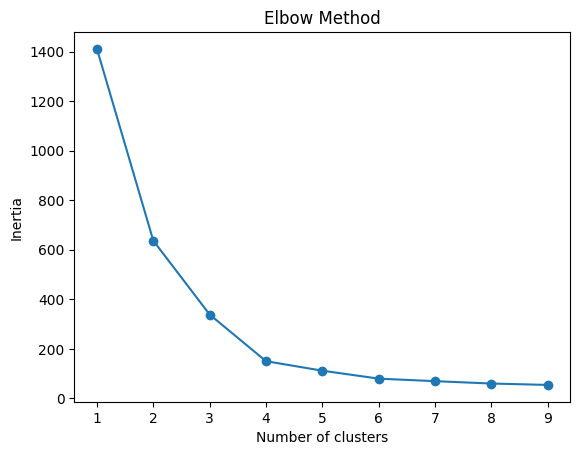

In [20]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 10), inertia, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()
n_clusters = 4

In [21]:
km = KMeans(4)
y = km.fit_predict(X).astype(str)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


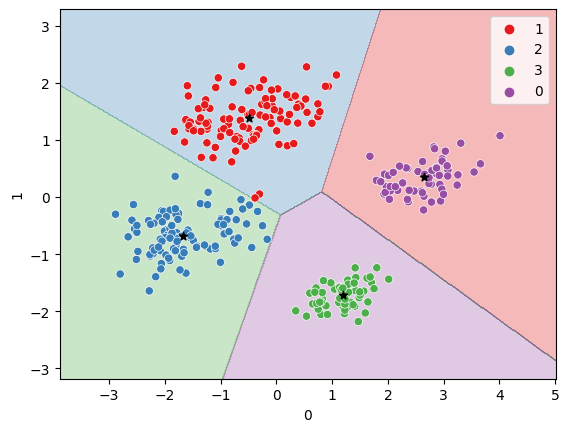

In [22]:

palette = sns.color_palette('Set1', n_colors=4)
cmap = ListedColormap(palette.as_hex()) #Para setear los colores y que coincidan con los puntos

#Vamos a hacer un decition boundary plot
x_min, x_max = X[0].min() - 1, X[0].max() + 1 #Identificamos mínimos y máximos en los datos
y_min, y_max = X[1].min() - 1, X[1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500)) #Crea una malla 2D
grid = np.c_[xx.ravel(), yy.ravel()] #Crea una grilla de valores aplanados para utilizar el algoritmo

labels = km.predict(grid) #Predice usando kmeans
labels = labels.reshape(xx.shape) #To 1D

fig, ax = plt.subplots()
ax.contourf(xx, yy, labels, alpha=0.3, cmap=cmap) #Plotear fondo
sns.scatterplot(X, x=0, y=1, hue=y, ax=ax, palette=palette)#Tuve que invertir el orden para que funcionara XD
plt.scatter(x = km.cluster_centers_[:,0], y= km.cluster_centers_[:,1], color="black", marker="*") #Plotear medias
plt.show()

In [23]:
silhouette_score(X, y), calinski_harabasz_score(X, y), davies_bouldin_score(X, y)

(0.6551502355737144, 917.1170653231517, 0.4546007123655713)

## Gaussian Mixture

In [24]:
def get_ellipse(index, n_std, color):
    cov = gm.covariances_[index] #Obtener la covarianza
    mean = gm.means_[index] #Obtener la media
    eigenval, eigenvec = np.linalg.eigh(cov) #Obtener los vectores y valores propios
    order = eigenval.argsort()[::-1] #Ordenar en orden decreciente
    eigenval = eigenval[order]
    eigenvec = eigenvec[:, order] #Ordenado
    angle = np.degrees(np.arctan2(eigenvec[1, 0], eigenvec[0, 0])) #Obtener el ángulo
    width, height = 2 * n_std * np.sqrt(eigenval)#Multiplicamos por la raiz del eigenval y un número de desviaciones estandar
    return Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=color,
                   fc=color, lw=0.1, alpha=0.1) #Retornar un elipse

In [25]:
gm = GaussianMixture(4, init_params="k-means++", random_state=1) #Seteé un random state para controlar la aleatoriedad
y = gm.fit_predict(X).astype(str)

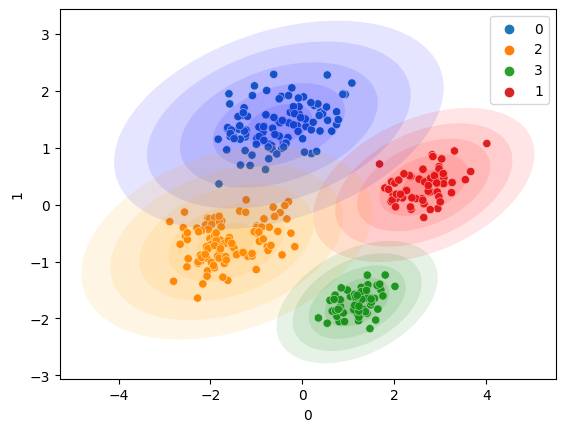

In [26]:
fig, ax = plt.subplots()
sns.scatterplot(X, x=0, y=1, hue=y)
for tup in [(0, "blue"), (1, "red"), (2, "orange"), (3, "green")]: #Hay que ajustar los colores para que se vea bien
    for i in range(1,6):
        ax.add_patch(get_ellipse(tup[0], i, tup[1]))
plt.show()

In [27]:
silhouette_score(X, y), calinski_harabasz_score(X, y), davies_bouldin_score(X, y)

(0.6528980592747389, 901.6548736451559, 0.45784598120640396)

## DBSCAN

<Axes: xlabel='0', ylabel='1'>

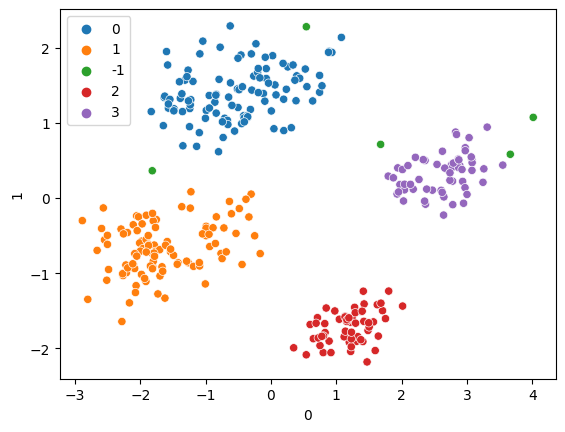

In [28]:
db = DBSCAN(eps=0.4, min_samples=5) #Probar a jugar con epsilon y min_samples
cluster = db.fit_predict(X).astype(str)
sns.scatterplot(X, x=0, y=1, hue=cluster)
#DBSCAN identifica automáticamente los outliers.

## Interpretación

<Axes: xlabel='0', ylabel='1'>

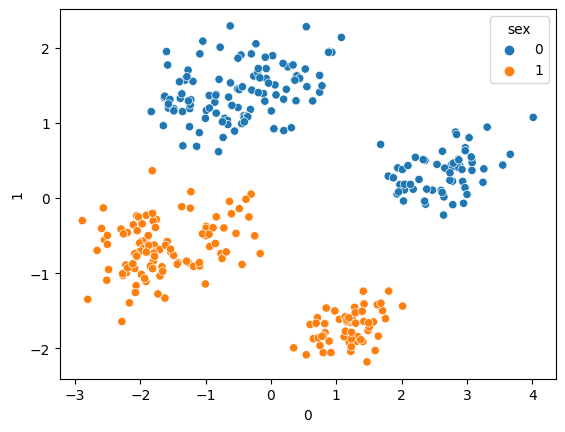

In [29]:
sns.scatterplot(X, x=0, y=1, hue=data.sex) #Los grupos se separan utilizando la columna sex.
#Podemos decir que nuestro clustering agrupa a 4 distintos grupos. La primera separación es por especie, la segunda por sexo. 